# Estimating Neandertal ancestry over time

In [1]:
library(here)
library(tidyverse)
library(future)
library(furrr)
plan(multiprocess)

library(admixr)
library(bdkn)

source(here("code/utils.R"))

here() starts at /mnt/expressions/mp/nea-over-time
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.7
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘bdkn’

The following object is masked from ‘package:ggplot2’:

    %+%


Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
samples <- load_samples() %>%
    filter(!pop %in% c("Oceania")) %>%
    mutate(name = case_when(name == "new_UstIshim" ~ "UstIshim",
                            name == "new_Loschbour" ~ "Loschbour",
                            TRUE ~ name))

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

## Calculate "direct" estimate of Nea. ancestry (on admixture array sites)

In [3]:
suppressMessages(
array_snps <- load_dataset(here("data/genotypes/ice_age.tsv"),
                           here("data/genotypes/sgdp.tsv"),
                           here("data/genotypes/archaics.tsv"),
                           filter_damage=TRUE,
                           random_sample=TRUE)
)

direct_nea <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"))) %>%
    summarise_all(function(ind) { mean(ind, na.rm=TRUE) / 2 }) %>%
    gather(name, alpha) %>%
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(alpha=mean(alpha))

In [4]:
snp_counts_direct <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"))) %>%
    summarise_all(function(ind) { sum(!is.na(ind)) }) %>% 
    gather(name, snp_count) %>% 
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

# Calculating Nea ancestry using different ratios of f4 statistics

We used the data set containing the new Vindija sample:

In [5]:
snps <- eigenstrat(here("data/eigenstrat/bigyri_ho/all"))

### Calculate the number of SNPs available for each sample on the 2.2M array

In [6]:
snp_counts_f4 <- count_snps(snps)

## Nea. ancestry proportions using the indirect f4-ratio

In [26]:
indirect_f4 %<-% {
    relabel(snps,
            West_and_Central_Africans = c("Yoruba", "Mbuti", "Mende"),
            Archaics = c("new_Altai", "new_Denisova")) %>%
    f4ratio(X = filter(samples, pop %in% c("EMH", "WestEurasia"))$name,
            A = "West_and_Central_Africans", B = "Archaics", C = "Dinka", O = "Chimp")
}

In [27]:
indirect_f4 %<>% mutate(stat = "indirect_f4")

In [9]:
afr_pops <- list(
    c("Yoruba", "Dinka"),
    c("Mbuti", "Dinka"),
    c("Khomani_San", "Dinka"),
    c("Mbuti", "Yoruba"),
    c("Khomani_San", "Yoruba"),
    c("Khomani_San", "Mbuti")
)

indirect_f4_combinations <- future_map_dfr(
    afr_pops,
    ~ f4ratio(X = filter(samples, pop %in% c("EMH", "WestEurasia"))$name,
            A = .x[1], B = "new_Altai", C = .x[2], O = "Chimp", data = snps)
)

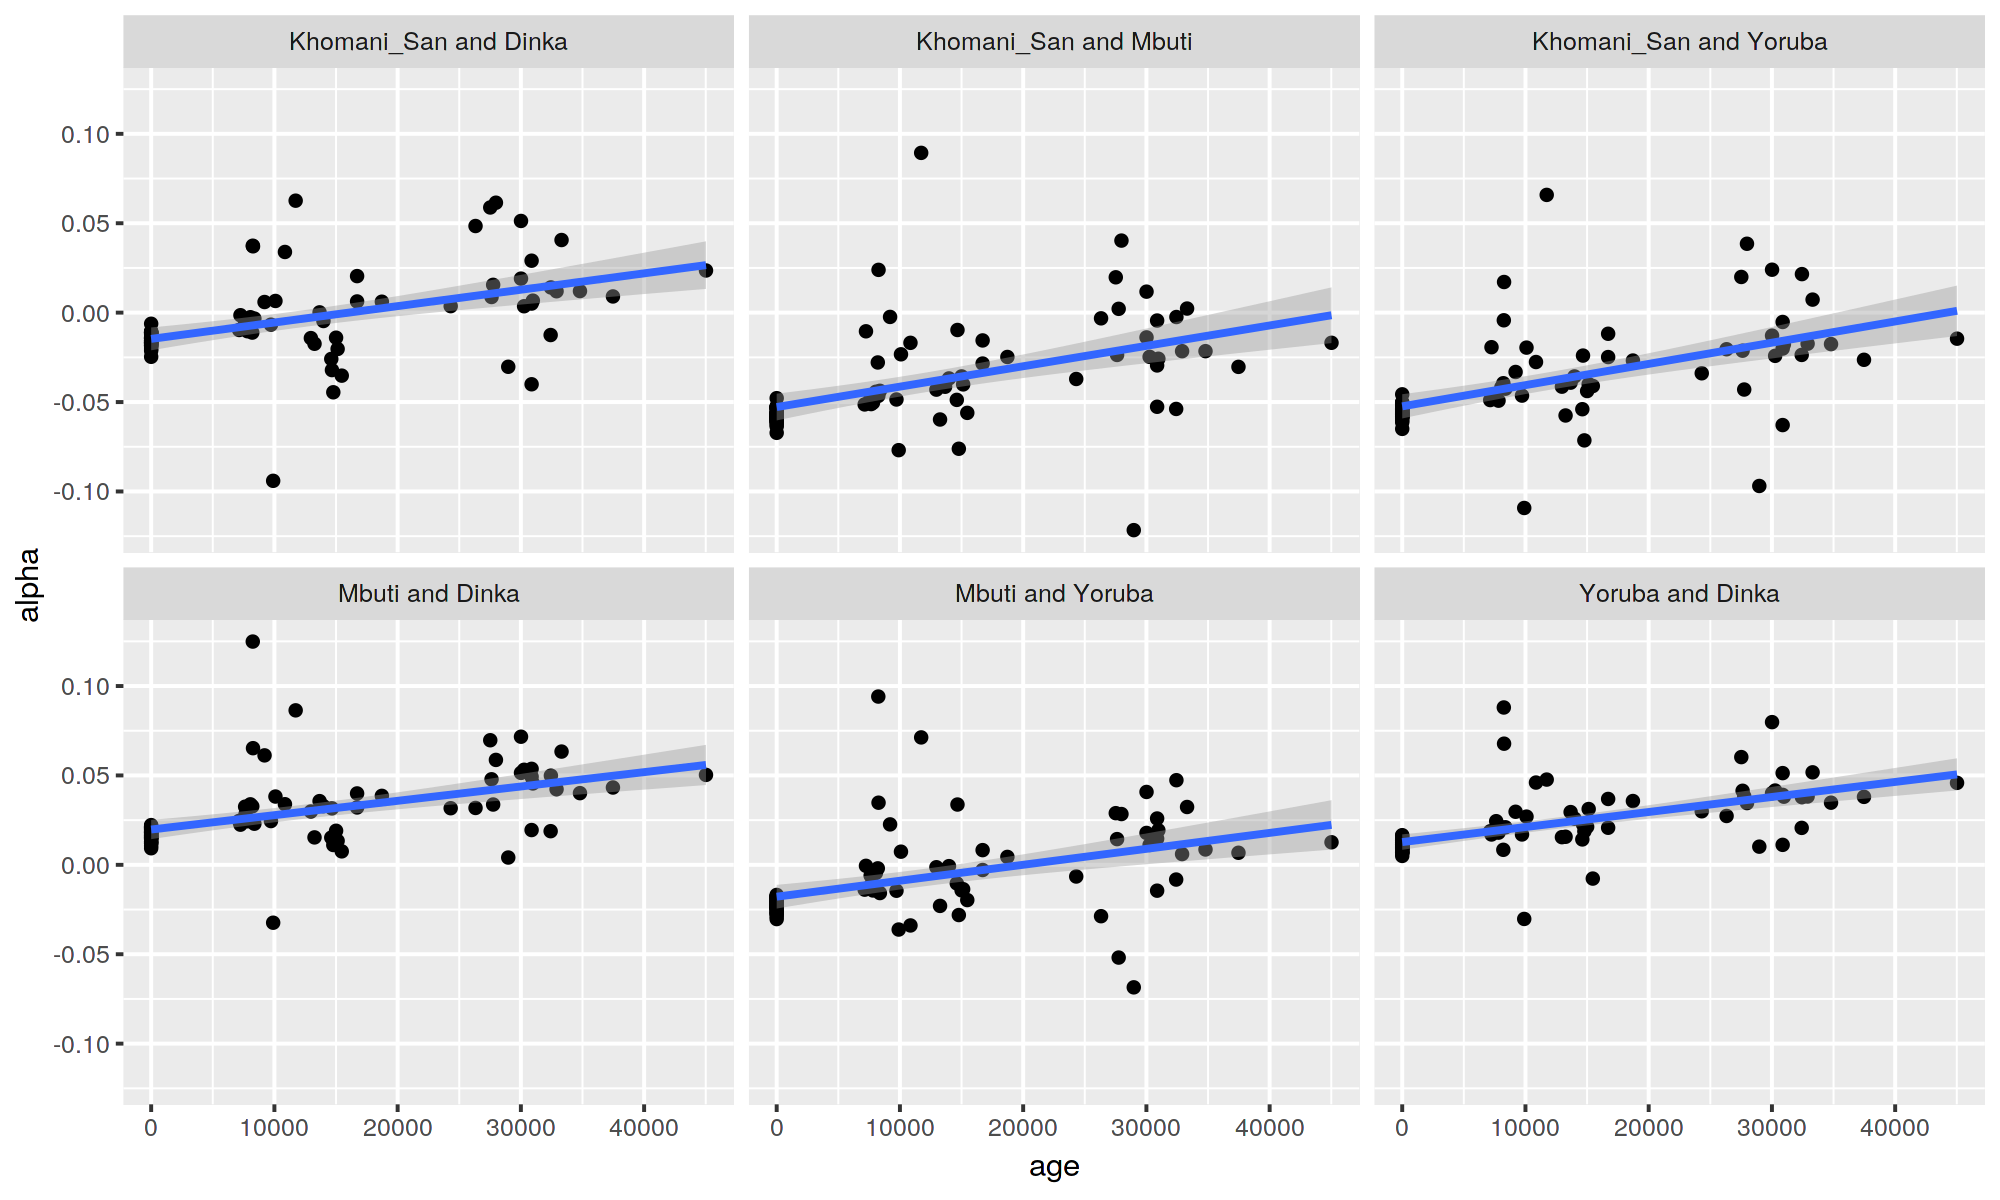

In [11]:
set_dim(10, 6, 200)

inner_join(indirect_f4_combinations, samples, by = c("X" = "name")) %>%
mutate(afr_pair = A %+% " and " %+% C) %>% 
ggplot(aes(age, alpha)) + geom_point() + geom_smooth(method = "lm") + facet_wrap(~ afr_pair)

## Nea. ancestry using the direct f4-ratio

More straightforward & should be measuring what we _really_ want to measure.

In [12]:
direct_f4 <- future_map_dfr(
    filter(samples, pop == "Africa")$name, 
    ~ f4ratio(X = filter(samples, pop %in% c("EMH", "WestEurasia"))$name,
            A = "new_Altai", B = "new_Vindija", C = .x, O = "Chimp", data = snps)
)
direct_f4 %<>% mutate(stat = "direct_f4")

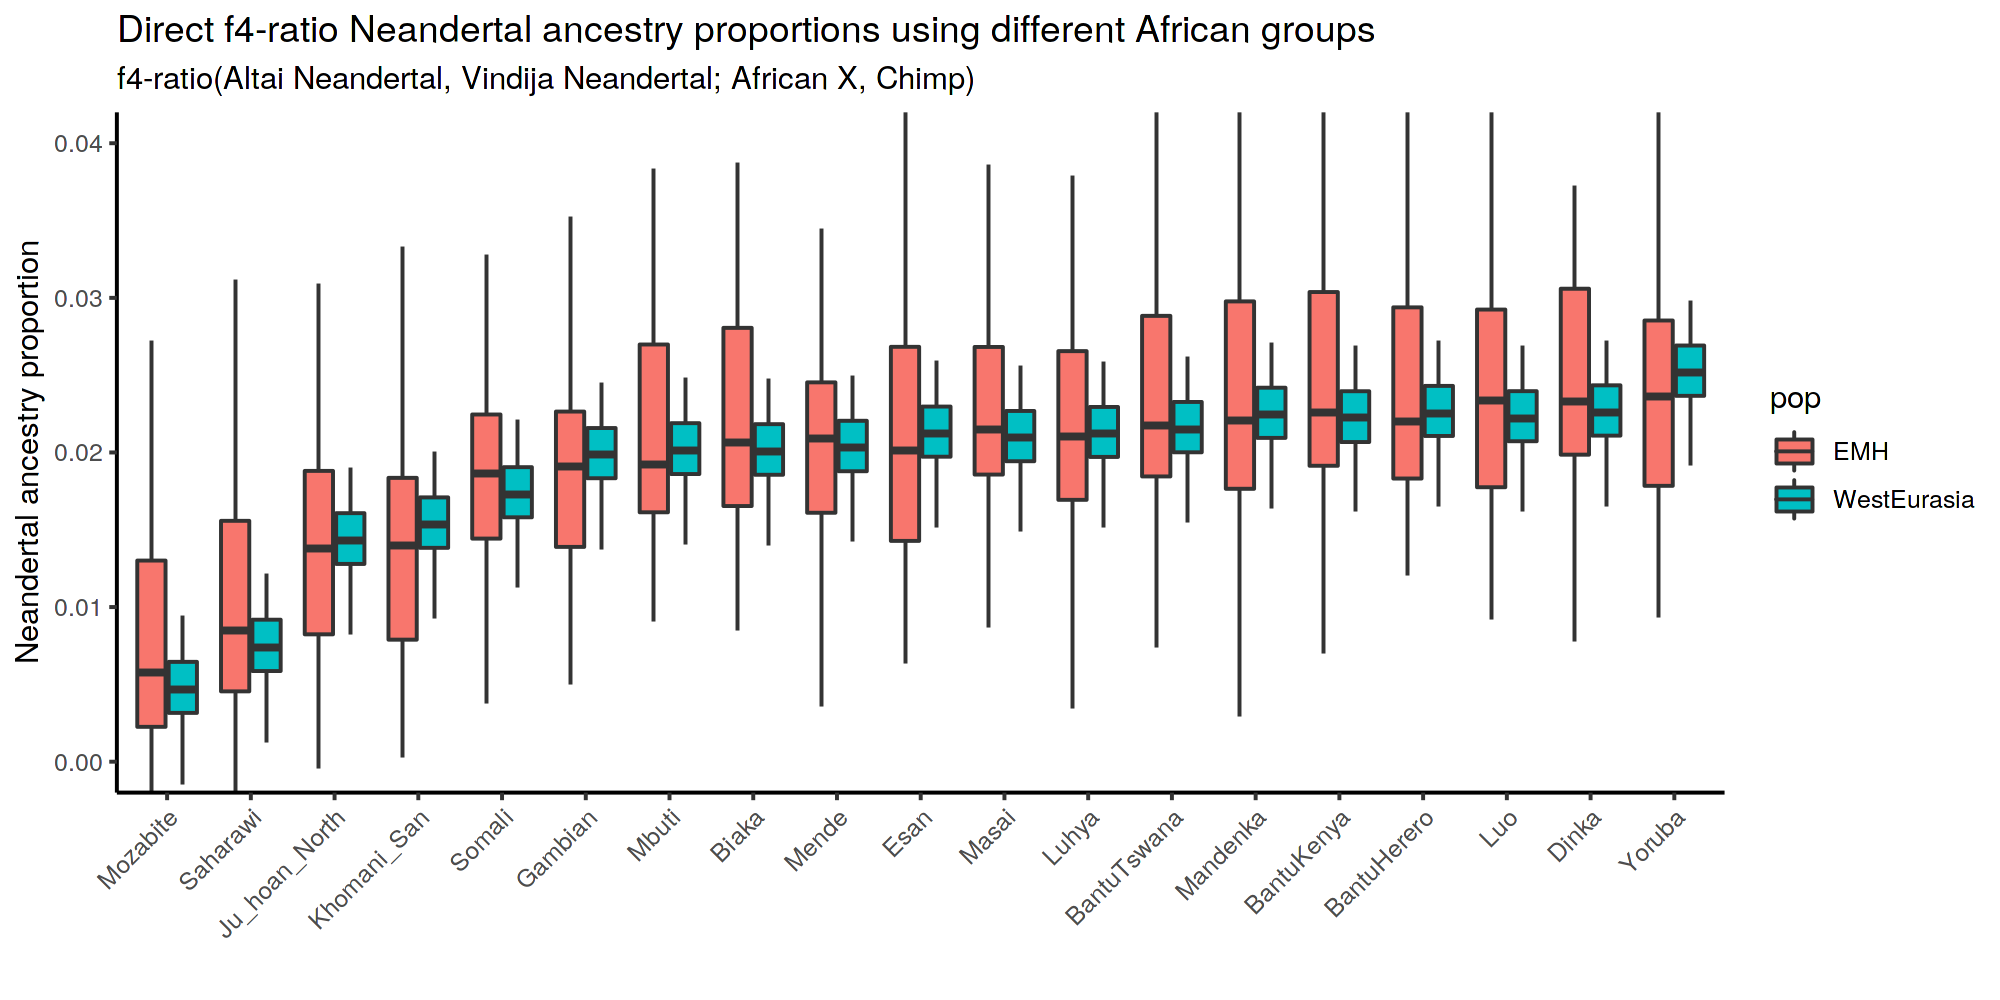

In [13]:
set_dim(10, 5, 200)

inner_join(direct_f4, samples, by = c("X" = "name")) %>%
ggplot(aes(fct_reorder(C, alpha), alpha, fill = pop)) +
    geom_boxplot(outlier.shape = NA) + coord_cartesian(y = c(0, 0.04)) +
    theme_classic() + theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("Direct f4-ratio Neandertal ancestry proportions using different African groups",
            "f4-ratio(Altai Neandertal, Vindija Neandertal; African X, Chimp)") +
    xlab("") + ylab("Neandertal ancestry proportion")

## qpAdm Neandertal ancestry estimates

In [14]:
qpAdm_result %<-% qpAdm(target = filter(samples, pop %in% c("EMH", "WestEurasia", "EastAsia"))$name,
                        references = c("new_Vindija", "Dinka"),
                        outgroups = c("Chimp", "new_Altai", "new_Denisova"),
                        data=snps)

In [18]:
qpAdm_result$proportions %<>% mutate(stat = "qpAdm")

In [22]:
qpAdm_result$proportions %>% head

target,new_Vindija,Dinka,stderr_new_Vindija,stderr_Dinka,nsnps,stat
UstIshim,0.02662380,0.9733762,0.004,0.004,2050585,qpAdm
Kostenki14,0.02315547,0.9768445,0.004,0.004,1676430,qpAdm
GoyetQ116-1,0.03314217,0.9668578,0.004,0.004,811826,qpAdm
Muierii2,0.01767066,0.9823293,0.009,0.009,95793,qpAdm
Paglicci133,0.02504458,0.9749554,0.009,0.009,79635,qpAdm
Cioclovina1,0.03675677,0.9632432,0.022,0.022,12426,qpAdm


### Merge all f4 results:

In [33]:
snp_counts_f4 %>% head

id,sex,label,present
Bichon,M,Bichon,2116782
KK1,M,Kotias,2133966
SATP,M,Satsurblia,1460368
Motala12,M,Motala12,1874519
I0004,M,Dolni13_nq,897796
I0007,M,Oberkassel_nq,57365


In [65]:
results <- bind_rows(
    inner_join(bind_rows(indirect_f4,
                         indirect_f4_combinations,
                         direct_f4,
                         mutate(qpAdm_result$proportions, C = "Dinka") %>% select(target, stat, C, new_Vindija, stderr = stderr_new_Vindija) %>% rename(X = target, alpha = new_Vindija)),
               rename(snp_counts_f4, snp_count = present), by = c("X" = "label")) %>% mutate(sites="all"),
    inner_join(direct_nea, snp_counts_direct) %>% rename(X = name) %>% mutate(sites = "admixture_array", stat = "admixture_prop")
) %>%
    inner_join(samples, by=c("X"="name"))

Joining, by = "name"


# Plot Nea. estimates over time

In [45]:
set_dim(9, 5)

In [46]:
non_udg_samples <- NULL #c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

In [47]:
near_east <- c("BedouinB", "Druze", "Iranian", "Iraqi_Jew", "Jordanian",
               "Palestinian", "Samaritan", "Yemenite_Jew")

In [69]:
eur_nea <- filter(results, pop %in% c("EMH", "WestEurasia"),
                  !X %in% non_udg_samples,
                  !X %in% near_east)

## Results from the Ice Age paper

In [98]:
cutoff <- 200000

In [100]:
set_dim(9, 5)

Warning message:
“Removed 48 rows containing missing values (geom_errorbar).”

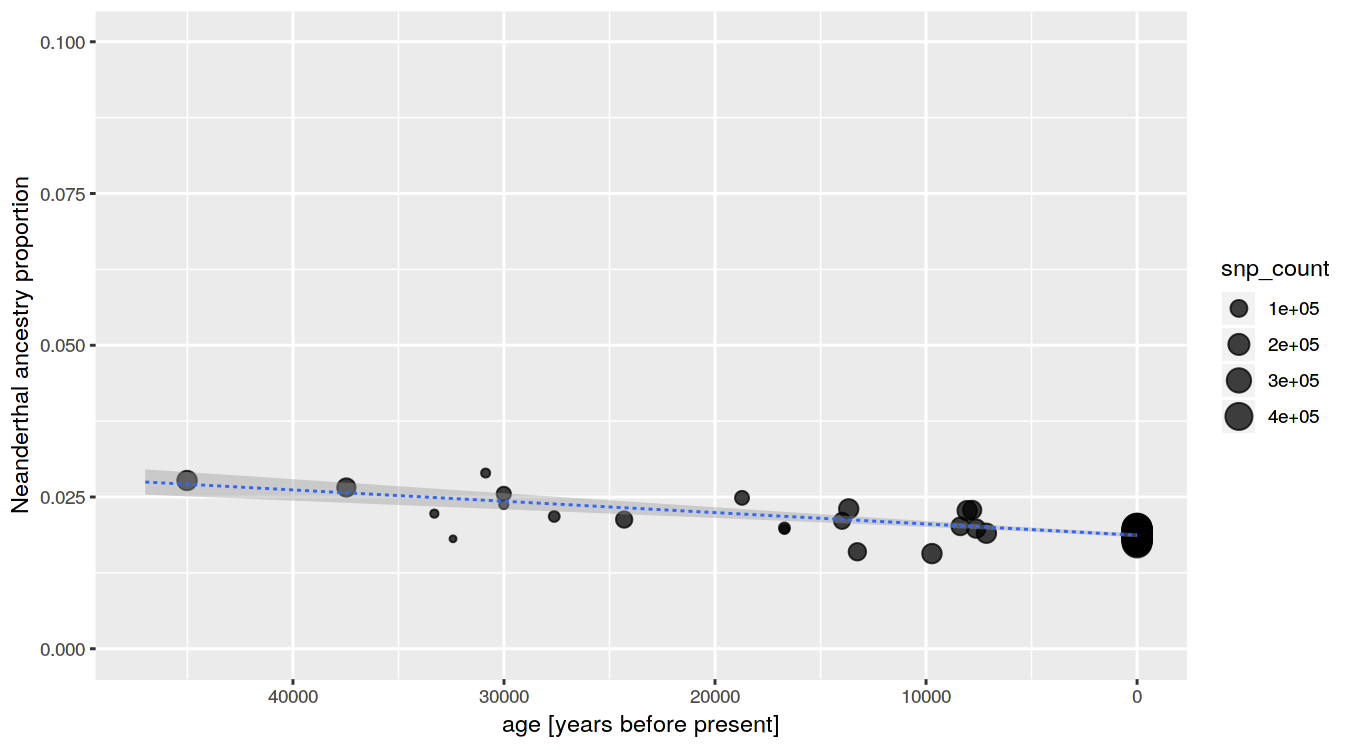

In [101]:
filter(eur_nea, stat == "admixture_prop") %>%
plot_nea_vs_time(snp_cutoff = 2000)

Warning message:
“Removed 2 rows containing missing values (geom_errorbar).”

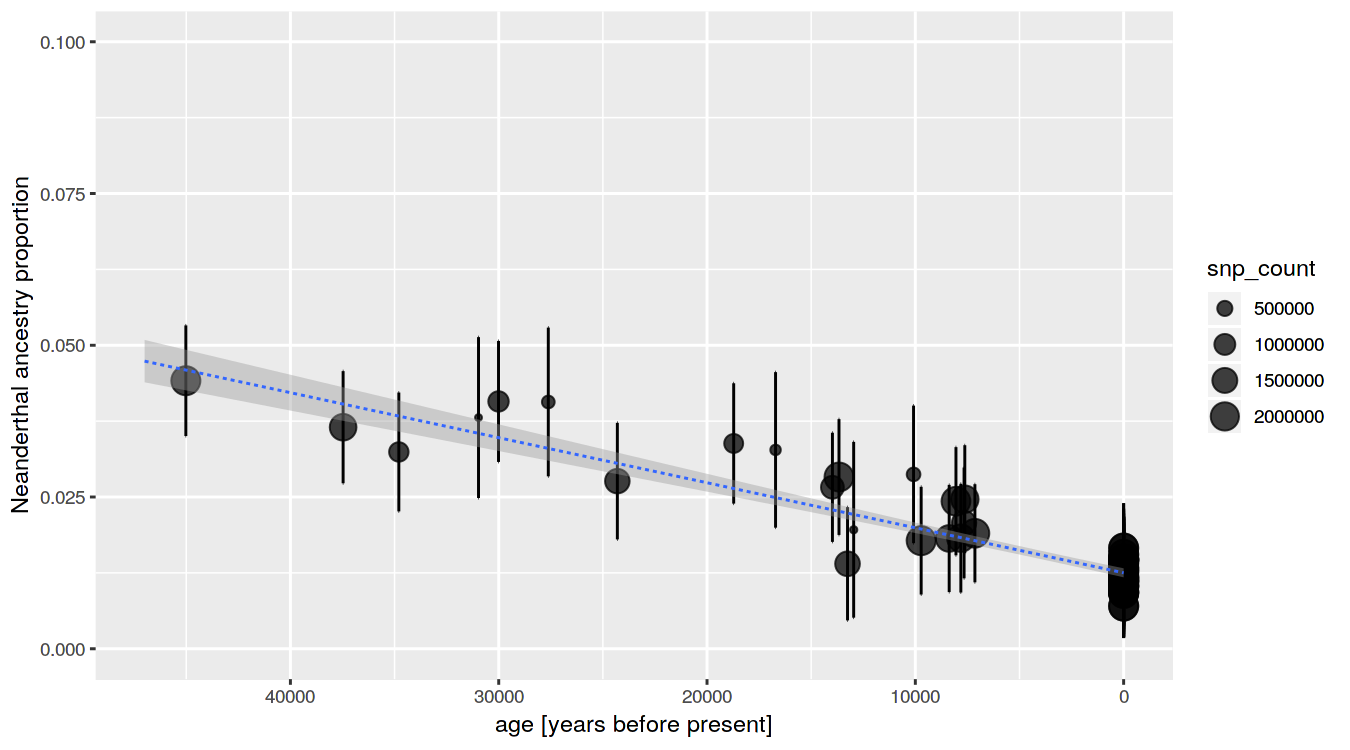

In [102]:
eur_nea %>% filter(A == "West_and_Central_Africans") %>%
plot_nea_vs_time(ylim = c(0, 0.1), snp_cutoff = cutoff)

# qpAdm results

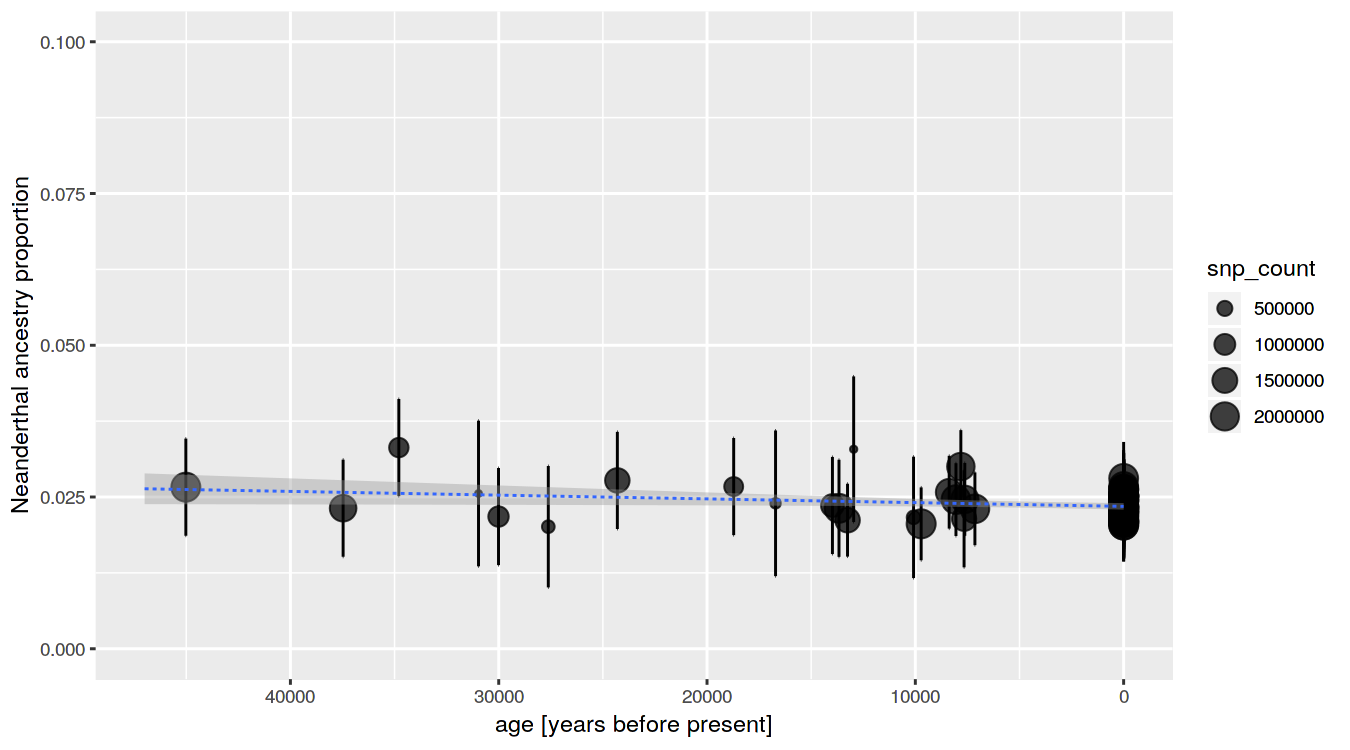

In [103]:
filter(eur_nea, stat == "qpAdm") %>% plot_nea_vs_time(., snp_cutoff = cutoff)

qpAdm vs direct f4

Warning message:
“Ignoring unknown parameters: a”

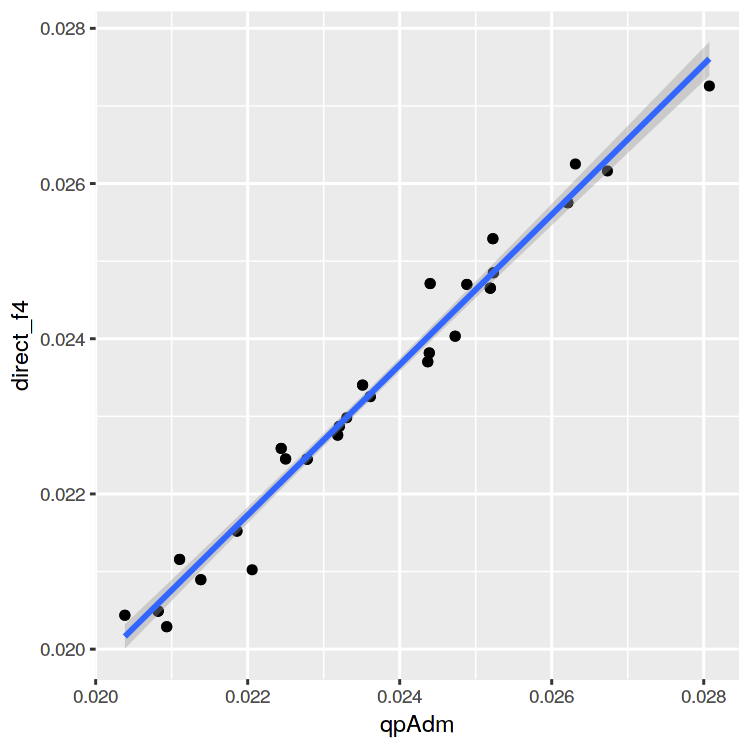

In [83]:
qplot(x = (eur_nea %>% filter(stat == "qpAdm", pop == "WestEurasia"))$alpha,
      y = (eur_nea %>% filter(stat == "direct_f4", pop == "WestEurasia", C == "Dinka"))$alpha,
      xlab = "qpAdm", ylab = "direct_f4") +
geom_smooth(a = 1, method = "lm")

# New f4 results

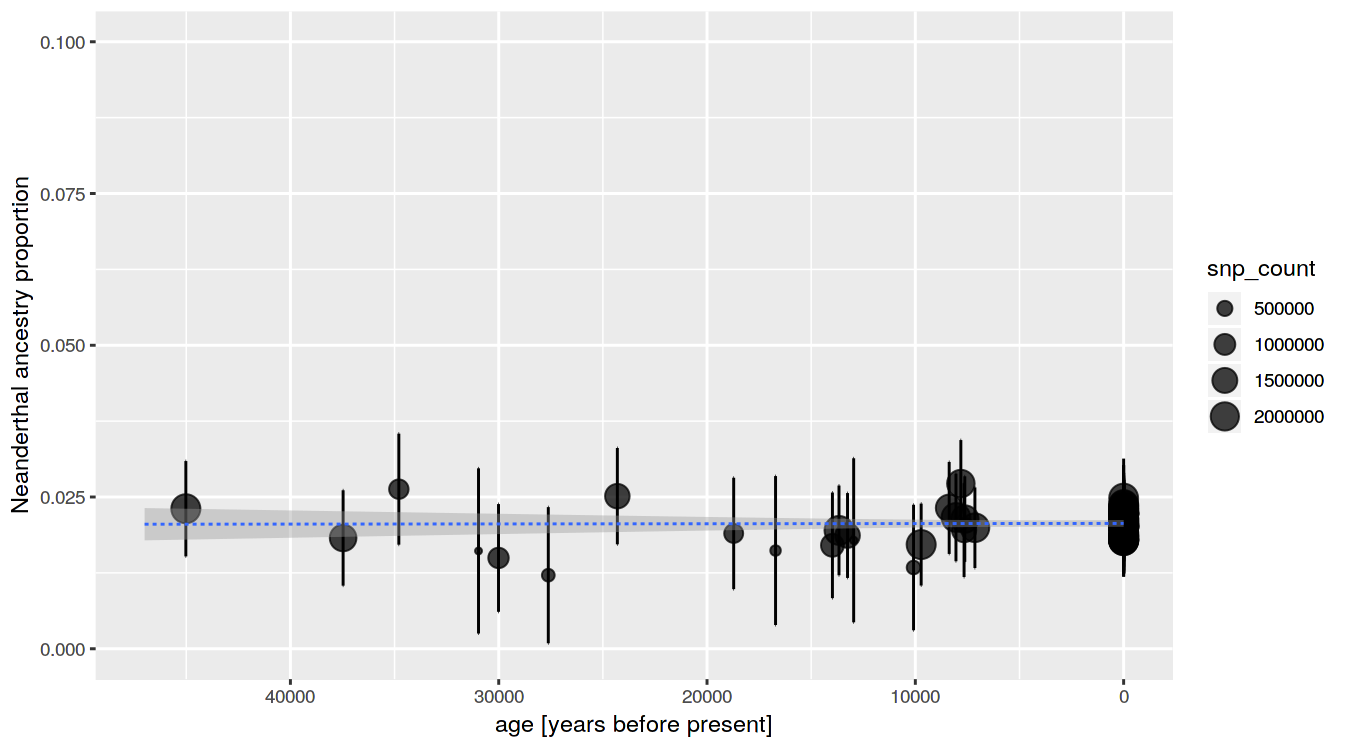

In [110]:
eur_nea %>% filter(stat == "direct_f4", C == "Mbuti") %>% plot_nea_vs_time(., snp_cutoff = cutoff)

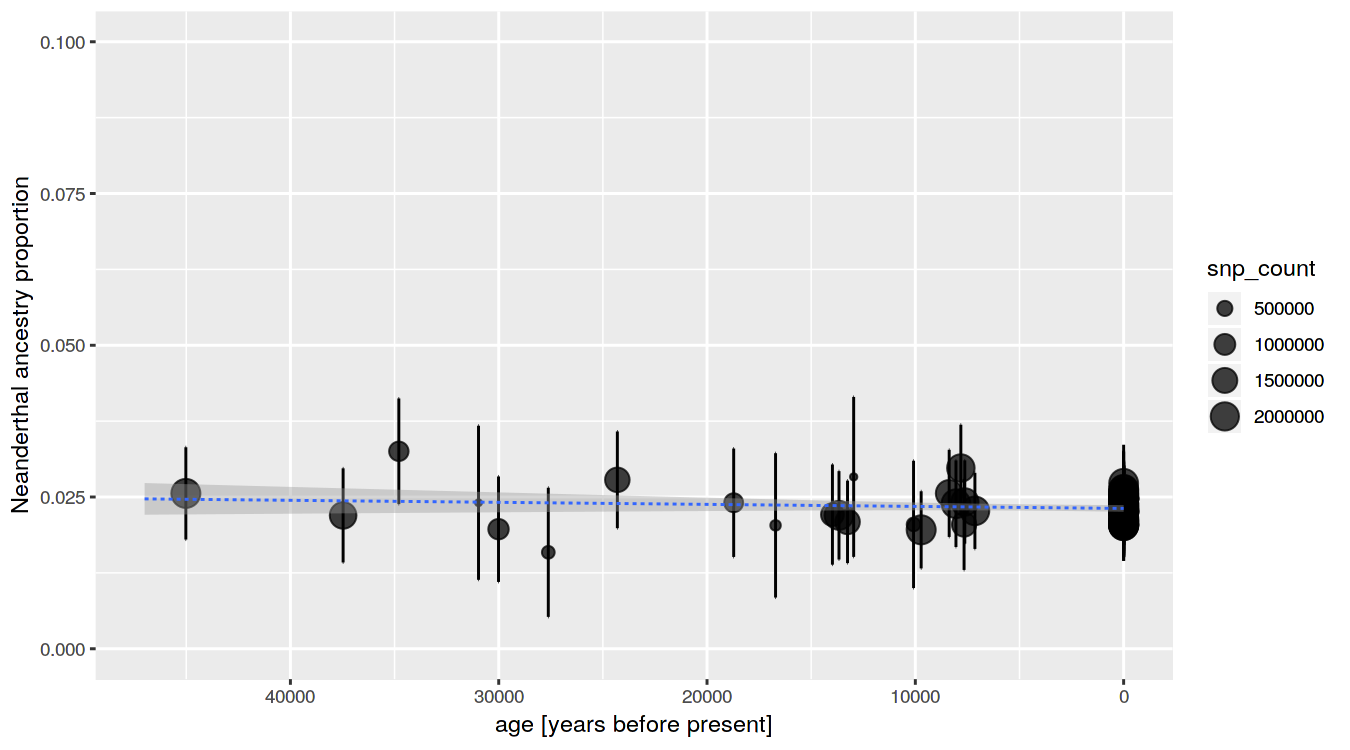

In [111]:
eur_nea %>% filter(stat == "direct_f4", C == "Dinka") %>% plot_nea_vs_time(., snp_cutoff = cutoff)

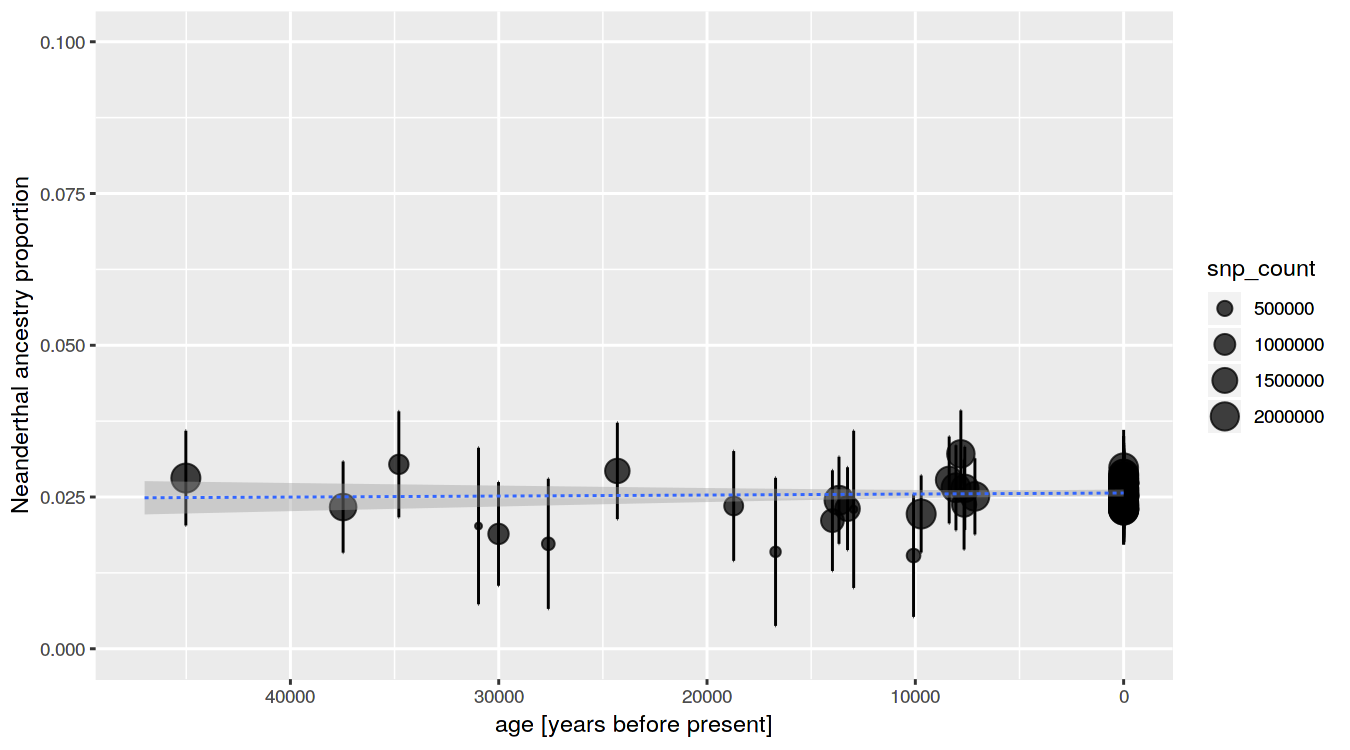

In [112]:
eur_nea %>% filter(stat == "direct_f4", C == "Yoruba") %>% plot_nea_vs_time(., snp_cutoff = cutoff)

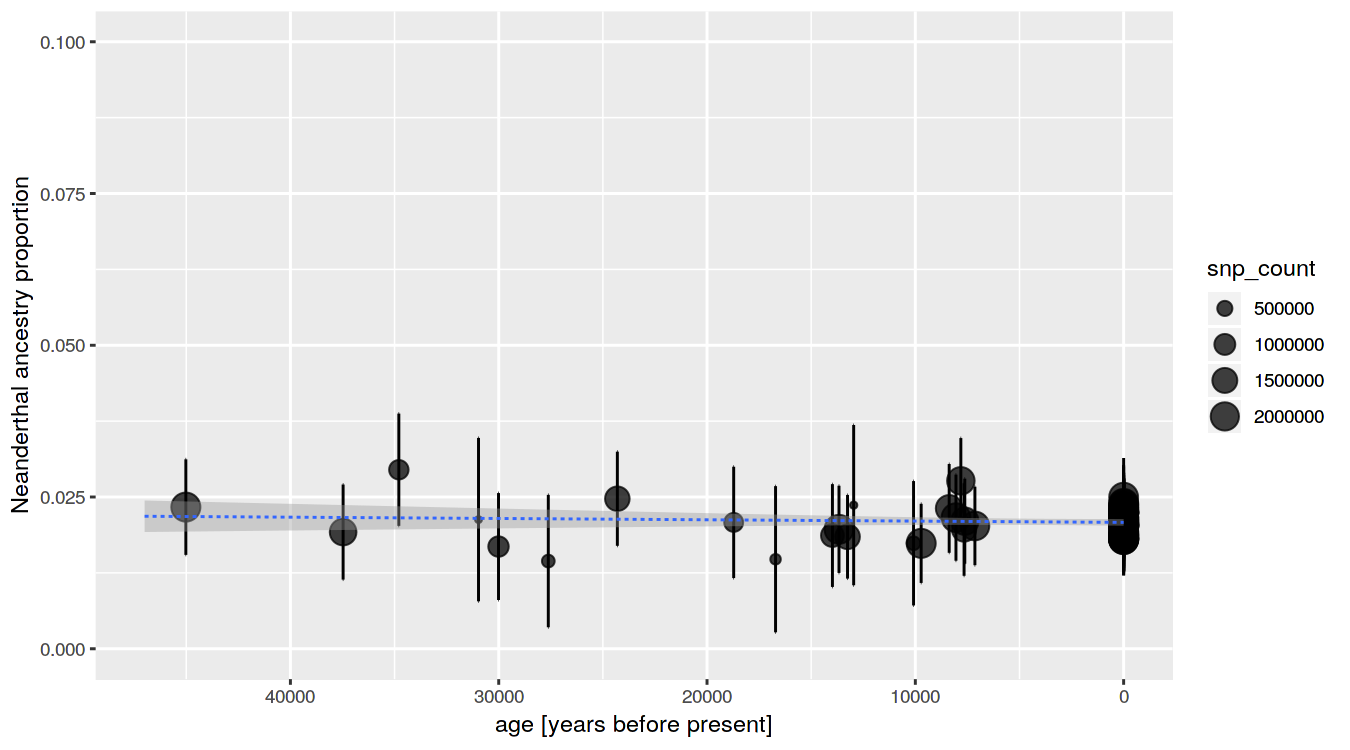

In [113]:
eur_nea %>% filter(stat == "direct_f4", C == "Mende") %>% plot_nea_vs_time(., snp_cutoff = cutoff)

# Write the admixture array estimates

In [108]:
saveRDS(results, here("data/rds/nea_estimates.rds"))

In [114]:
results <- readRDS(here("data/rds/nea_estimates.rds"))